In [2]:
import json
from pathlib import Path

import networkx as nx
import numpy as np

import matplotlib.pyplot as plt

In [67]:
ROOT = Path()

WEBQSP = ROOT / 'data/webqsp/test.json'
SR_WEBQSP = ROOT / 'data/sr-webqsp/test.json'

In [4]:

def analyze(path: str | Path):
    with open(path) as fin:
        data = json.loads(fin.readline())

    print('edges = ', len(data['subgraph']['tuples']))

    if 'paths' in data:
        print(data['paths'])

In [5]:
print('BEFORE:')
analyze(WEBQSP)
print()
print('AFTER:')
analyze(SR_WEBQSP)

BEFORE:
edges =  5444

AFTER:
edges =  15
[['m.03_r3', ['location.country.languages_spoken', 'END OF HOP']], ['m.03_r3', ['location.country.official_language', 'END OF HOP']], ['m.03_r3', ['location.country.official_language', 'en', 'END OF HOP']], ['m.03_r3', ['location.country.languages_spoken', 'en', 'END OF HOP']], ['m.03_r3', ['base.dspl.world_bank.wdi_gdf.country', 'END OF HOP']], ['m.03_r3', ['location.location.containedby', 'END OF HOP']], ['m.03_r3', ['location.country.calling_code', 'END OF HOP']], ['m.03_r3', ['base.locations.countries.continent', 'END OF HOP']], ['m.03_r3', ['location.country.languages_spoken', 'type.object.name', 'END OF HOP']], ['m.03_r3', ['location.country.languages_spoken', 'type.object.type', 'END OF HOP']]]


In [6]:
with open('./data/webqsp/entities.txt') as fin:
    id2entity = {}
    idx = 0
    for line in fin:
        id2entity[idx] = line.strip()
        idx += 1

with open('./data/webqsp/relations.txt') as fin:
    id2relation = {}
    idx = 0
    for line in fin:
        id2relation[idx] = line.strip()
        idx += 1

In [7]:
with open('./entities_names.json') as fin:
    entity2name = json.load(fin)

In [217]:
with open(SR_WEBQSP) as fin, open(WEBQSP) as real_fin, open('_test (3).info') as info_fin:
    # for _ in range(1):
    #     fin.readline(), real_fin.readline(), info_fin.readline()

    for _ in range(100):
        fin.readline(), real_fin.readline(), info_fin.readline()

    # for _ in range(453):
    #     fin.readline(), real_fin.readline(), info_fin.readline()

    data = json.loads(fin.readline())
    real_data = json.loads(real_fin.readline())
    info_data = json.loads(info_fin.readline())

In [218]:
nodes = [node for node, _ in info_data['cand']]

In [219]:
def extract_subgraph(G, nodes):
    for node1 in nodes:
        for node2 in G[node1]:
            if node2 in nodes and node1 != node2:
                yield node1, node2

In [220]:
real_G = nx.DiGraph()

for source, relation, target in real_data['subgraph']['tuples']:
    real_G.add_edge(id2entity.get(source, None), id2entity.get(target, None), relation=id2relation.get(relation, None))

print(real_G.number_of_nodes(), real_G.number_of_edges())
real_degrees = dict(real_G.out_degree())

2000 5125


In [221]:
list(map(lambda x: (entity2name.get(x[0], x[0]), x[1]), sorted(real_degrees.items(), key=lambda x: -x[1])))

[('Google', 533),
 ('Android', 46),
 ('Google Apps for Work', 39),
 ('Google Analytics', 33),
 ('m.011qxpsj', 31),
 ('Kerr Communications', 29),
 ('Google Docs, Sheets, and Slides', 29),
 ('Google Search', 29),
 ('Larry Page', 23),
 ('m.0hj5yrd', 23),
 ('m.09ytsl', 23),
 ('Gmail', 23),
 ('Lino Uruñuela', 22),
 ('Menashe Avramov', 21),
 ('App Inventor for Android', 21),
 ('Eight Habits of Highly Effective Google Managers', 20),
 ('Google Toolbar', 20),
 ('Nick Ker', 20),
 ('Joel Glenn Wright', 19),
 ('Google+', 19),
 ('Cleverly Engaged Marketing', 19),
 ('Web Standards: Mastering HTML5, CSS3, and XML', 19),
 ('m.06t7r9', 19),
 ('Leadership agenda 2012', 18),
 ('m.05kjb0y', 18),
 ('Google News', 18),
 ('Network Security Services', 18),
 ('Shawn Harding', 17),
 ('Google for Work', 17),
 ('KHTML', 17),
 ('AdWords', 17),
 ('m.0g4gr', 17),
 ('Online advertising', 17),
 ('iOS', 17),
 ('V8', 17),
 ('Google Cloud Platform', 17),
 ('m.01310mby', 17),
 ('Google Voice', 17),
 ('Sergey Brin', 16),


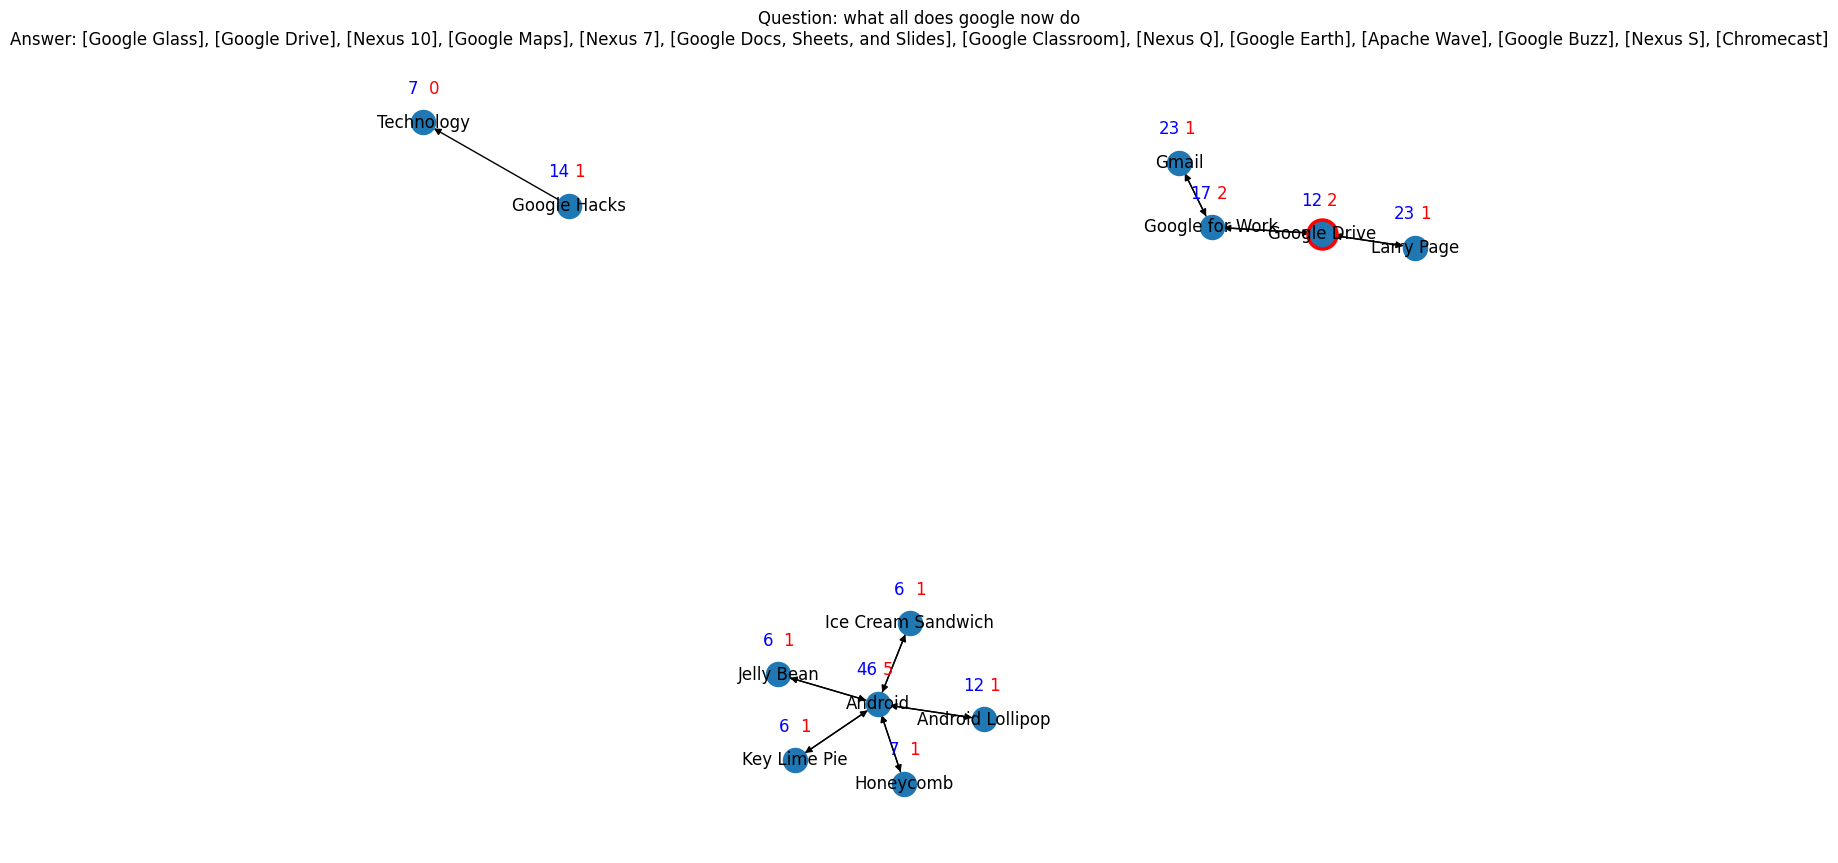

In [222]:
G = nx.DiGraph()

bad_nodes = 0
# for node in data['subgraph']['entities']:
#     if node in real_G:
#         G.add_node(node, real_degree=real_degrees[node], name=entity2name.get(node, node))
#     else:
#         bad_nodes += 1

# for source, relation, target in data['subgraph']['tuples']:
#     G.add_edge(source, target, relation=relation)

for source, target in extract_subgraph(real_G, nodes):
    if source not in G:
        G.add_node(source, real_degree=real_degrees.get(source, -1), name=entity2name.get(source, source))
    if target not in G:
        G.add_node(target, real_degree=real_degrees.get(target, -1), name=entity2name.get(target, target))
    G.add_edge(source, target, relation=real_G[source][target]['relation'])

# pos = nx.bfs_layout(G, data['entities'])
pos = nx.spring_layout(G)

plt.figure(figsize=(12, 8))
nx.draw(G, pos=pos, with_labels=False)


# labels = nx.get_edge_attributes(G, 'relation')
# nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=labels)

real_degrees_at = nx.get_node_attributes(G, 'real_degree')
degrees = dict(G.out_degree())
pos_up_l = {key: pos[key] + np.array((-0.02, 0.09)) for key in pos}
pos_up_r = {key: pos[key] + np.array((0.02, 0.09)) for key in pos}
nx.draw_networkx_labels(G, pos_up_l, labels=real_degrees_at, font_color='blue')
nx.draw_networkx_labels(G, pos_up_r, labels=degrees, font_color='red')

names = nx.get_node_attributes(G, 'name')
nx.draw_networkx_labels(G, pos, labels=names)

keys = data['entities'].copy()
for d in data['answers']:
    keys.append(d['kb_id'])

x = np.array([pos[key] for key in keys if key in pos])
if len(x):
    plt.scatter(x[:,0], x[:,1], c='r', s=500)

s = ', '.join([f"[{d['text']}]" for d in data['answers']])
plt.title(f"Question: {data['question']}\nAnswer: {s}") # \nBad nodes: {bad_nodes} - not presented in original subgraph"

plt.axis("off")
plt.show();

In [148]:
print(data['answers'])
for path in data['paths']:
    start = path[0]
    rels = path[1][:-1]

    rel_index = 0
    path_edges = []

    def resolve(node):
        global rel_index
        global path_edges

        if rel_index == len(rels):
            return

        for next_node in G[node]:
            if G[node][next_node]['relation'] == rels[rel_index]:
                rel_index += 1
                path_edges.append((node, next_node))
                resolve(next_node)
                break
    
    resolve(start)
    print(path_edges)



[{'kb_id': 'm.0jm74', 'text': 'Chicago Bulls'}]
[('m.0c2yrf', 'm.0j2gdp4'), ('m.0j2gdp4', 'm.0jm74')]
[('m.0c2yrf', 'm.0j2gdp4'), ('m.0j2gdp4', '11300000.0')]
[('m.0c2yrf', 'm.0n819kn'), ('m.0n819kn', 'm.02q6by8')]
[('m.0c2yrf', 'm.0j2gdp4')]
[('m.0c2yrf', 'm.02nqxbv'), ('m.02nqxbv', 'm.0jm74')]
[('m.0c2yrf', 'm.010c7kcl'), ('m.010c7kcl', 'm.0jm74')]
[('m.0c2yrf', 'm.0j2gdp4'), ('m.0j2gdp4', '2012')]
[('m.0c2yrf', 'm.0j2gdp4'), ('m.0j2gdp4', 'm.09nqf')]
[('m.0c2yrf', 'm.010c7kcl'), ('m.010c7kcl', 'm.0t51fsg')]
[('m.0c2yrf', 'm.02nqxbv'), ('m.02nqxbv', 'm.0f4vx0')]
